# Support Vector Machines (SVM) Model Analysis Walkthrough (Dynamic Rollover)

Support Vector Machines (SVM) are supervised machine learning models that aim to find the hyperplane that best divides a dataset into classes. The core concept is to maximize the margin between the classes. The SVM searches for the closest points (support vectors) and attempts to set the boundary in the middle of them. SVMs can also be used for regression tasks.

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, make_scorer, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SMOTE, RandomOverSampler
from pathlib import Path

In [2]:
# this is the path to your pickle file (should be the same location as CSVs)
path = Path('../data')

with open(path / 'dynamic_rollover_pandas_2.0.2.pkl', 'rb') as file:
    df = pickle.load(file)
df = df.reset_index(drop=True)

## Dataset Splitting
We begin by splitting our dataset into a training and testing set. This process ensures that we have a distinct set of data to evaluate the model's performance.

In [3]:
# define independent variables and dependent variable
maneuver = 'Dynamic Rollover'
X = df.drop(maneuver, axis=1)
y = df[maneuver]

In [4]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Build and Fit the Model
We will set up a parameter grid with the best parameters. These parameters were developed in the modeling directory in the decision tree (dynamic rollover) file. For more information on the training and tuning of this model please refer to the modeling file.

In [5]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

In [6]:
# parameter grid for finding the best hyperparameters
params = {
    'svm__gamma': [1],
    'svm__C': [1000],
    'svm__kernel': ['rbf'],
    'svm__class_weight': ['balanced'],
    'svm__random_state': [42]
}

In [7]:
# grid search with cross-validation
f1_scorer = make_scorer(f1_score)
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# instantiate the grid search loading pipeline, parameters, k-fold, and scorer
grid_search = GridSearchCV(estimator=pipe, param_grid=params, cv=strat_k_fold, scoring=f1_scorer)
# fit the grid search
grid_search.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [1000], 'svm__class_weight': ['balanced'],
                         'svm__gamma': [1], 'svm__kernel': ['rbf'],
                         'svm__random_state': [42]},
             scoring=make_scorer(f1_score))

## Make Predictions for Model Evaluation

In [8]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9999    0.9992    0.9996     51270
           1     0.9236    0.9941    0.9576       511

    accuracy                         0.9991     51781
   macro avg     0.9618    0.9967    0.9786     51781
weighted avg     0.9992    0.9991    0.9991     51781



In [9]:
print(confusion_matrix(y_test, y_pred))

[[51228    42]
 [    3   508]]


## Visualizations
These visualizations will provide a comprehensive understanding of the model's performance, the features that drive decisions, and how the model's performance evolves as more data is added.

### Exploring C Values
The 'C' parameter in SVMs determines the trade-off between achieving a low error on the training data and maximizing the margin between classes. Let's see how different values of 'C' impact our model's performance.

[0.9575871819038642]
[0.9941291585127201]
[0.9236363636363636]
[0.9575871819038642, 0.9575871819038642]
[0.9941291585127201, 0.9941291585127201]
[0.9236363636363636, 0.9236363636363636]
[0.9575871819038642, 0.9575871819038642, 0.9575871819038642]
[0.9941291585127201, 0.9941291585127201, 0.9941291585127201]
[0.9236363636363636, 0.9236363636363636, 0.9236363636363636]
[0.9575871819038642, 0.9575871819038642, 0.9575871819038642, 0.9575871819038642]
[0.9941291585127201, 0.9941291585127201, 0.9941291585127201, 0.9941291585127201]
[0.9236363636363636, 0.9236363636363636, 0.9236363636363636, 0.9236363636363636]
[0.9575871819038642, 0.9575871819038642, 0.9575871819038642, 0.9575871819038642, 0.9575871819038642]
[0.9941291585127201, 0.9941291585127201, 0.9941291585127201, 0.9941291585127201, 0.9941291585127201]
[0.9236363636363636, 0.9236363636363636, 0.9236363636363636, 0.9236363636363636, 0.9236363636363636]


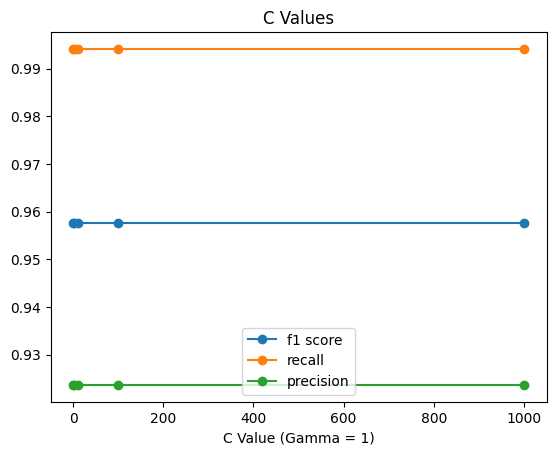

In [10]:
# C Values

# define lists to collect scores
test_f1_scores = list()
test_recall_scores = list()
test_prec_scores = list()

# define list of C values to plot
c_values = [0.1, 1, 10, 100, 1000]

for c in c_values:
    # evaluate test dataset
    test_yhat = best_model.predict(X_test)
    test_f1 = f1_score(y_test, test_yhat)
    test_recall = recall_score(y_test, test_yhat)
    test_prec = precision_score(y_test, test_yhat)
    test_f1_scores.append(test_f1)
    print(test_f1_scores)
    test_recall_scores.append(test_recall)
    print(test_recall_scores)
    test_prec_scores.append(test_prec)
    print(test_prec_scores)    

test_f1_scores

# plot of train and test scores vs tree depth
plt.plot(c_values, test_f1_scores, '-o', label='f1 score')
plt.plot(c_values, test_recall_scores, '-o', label='recall')
plt.plot(c_values, test_prec_scores, '-o', label='precision')
plt.title("C Values")
plt.legend()
plt.xlabel("C Value (Gamma = 1)")
plt.show()

### Exploring Gamma Values

The gamma parameter is specific to the 'rbf' kernel in SVMs. It defines how far the influence of a single training example reaches. A low gamma means ‘far’ while a high gamma means ‘close’. Let's visualize its impact on our model's performance.

[0.9575871819038642]
[0.9941291585127201]
[0.9236363636363636]
[0.9575871819038642, 0.9575871819038642]
[0.9941291585127201, 0.9941291585127201]
[0.9236363636363636, 0.9236363636363636]
[0.9575871819038642, 0.9575871819038642, 0.9575871819038642]
[0.9941291585127201, 0.9941291585127201, 0.9941291585127201]
[0.9236363636363636, 0.9236363636363636, 0.9236363636363636]
[0.9575871819038642, 0.9575871819038642, 0.9575871819038642, 0.9575871819038642]
[0.9941291585127201, 0.9941291585127201, 0.9941291585127201, 0.9941291585127201]
[0.9236363636363636, 0.9236363636363636, 0.9236363636363636, 0.9236363636363636]
[0.9575871819038642, 0.9575871819038642, 0.9575871819038642, 0.9575871819038642, 0.9575871819038642]
[0.9941291585127201, 0.9941291585127201, 0.9941291585127201, 0.9941291585127201, 0.9941291585127201]
[0.9236363636363636, 0.9236363636363636, 0.9236363636363636, 0.9236363636363636, 0.9236363636363636]


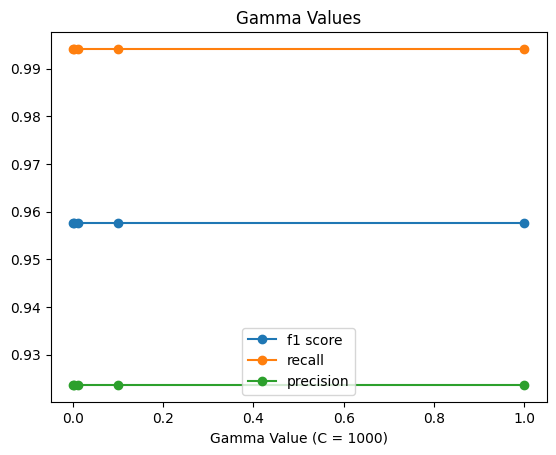

In [11]:
# Gamma Values

# define lists to collect scores
test_f1_scores = list()
test_recall_scores = list()
test_prec_scores = list()

# define list of C values to plot
gamma_values = [1, 0.1, 0.01, 0.001, 0.0001]

for g in gamma_values:
    # evaluate test dataset
    test_yhat = best_model.predict(X_test)
    test_f1 = f1_score(y_test, test_yhat)
    test_recall = recall_score(y_test, test_yhat)
    test_prec = precision_score(y_test, test_yhat)
    test_f1_scores.append(test_f1)
    print(test_f1_scores)
    test_recall_scores.append(test_recall)
    print(test_recall_scores)
    test_prec_scores.append(test_prec)
    print(test_prec_scores)


# plot of train and test scores vs tree depth
plt.plot(gamma_values, test_f1_scores, '-o', label='f1 score')
plt.plot(gamma_values, test_recall_scores, '-o', label='recall')
plt.plot(gamma_values, test_prec_scores, '-o', label='precision')
plt.legend()
plt.title("Gamma Values")
plt.xlabel("Gamma Value (C = 1000)")
plt.show()